<a href="https://colab.research.google.com/github/xascendent/AIEcolab/blob/main/Prototyping_LangChain_Application_with_Production_Minded_Changes_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 13.9 MB/s eta 0:00:00


We'll need an OpenAI API Key:

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - 85adb1ca


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

⚠ If you're running in a non-Chrome browser - you may run into issues with this cell. Please upload the file using Colab's file upload - and indicate the `file_path` in the cell with `file_path`. ⚠

![image](https://i.imgur.com/Qa1Uwlj.png)



> NOTE: You can skip this step if you are running locally - please just point to your local file.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving DeepSeek_R1.pdf to DeepSeek_R1.pdf


In [6]:
file_path = list(uploaded.keys())[0]
file_path

'DeepSeek_R1.pdf'

We'll define our chunking strategy.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [9]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

---
A: In our breakout we talked about how it could be very expensive to run if not managed correctly.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [20]:
from datetime import datetime

for i in range(3):
    start_time = datetime.now()
    retriever.invoke("What is GRPO?")
    end_time = datetime.now()
    time_taken = (end_time - start_time).total_seconds()
    print(f"Output {i + 1} time taken: {time_taken:.4f} seconds")


Output 1 time taken: 0.4642 seconds
Output 2 time taken: 0.4812 seconds
Output 3 time taken: 0.4601 seconds


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [13]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [14]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [15]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

---
A: In our group we talked aboutr if we cache everything then memory will become an issue.  Solution is to possibly cache common sets and not everything.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [21]:
import time
from langchain_openai import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings

chat_model = ChatOpenAI(model="gpt-4o-mini")
store = LocalFileStore("./cache/")
set_llm_cache(InMemoryCache())

# Test cases with sample context
test_cases = [
{
    "question": "What is quantum computing?",
    "context": "Quantum computing is a type of computing that harnesses quantum phenomena like superposition and entanglement. Unlike classical computers that use bits, quantum computers use quantum bits or qubits."
},
{
    "question": "What is quantum computing?",  # Same question to test cache
    "context": "Quantum computing is a type of computing that harnesses quantum phenomena like superposition and entanglement. Unlike classical computers that use bits, quantum computers use quantum bits or qubits."
}
]

# Run tests and measure response times
response_times = []
responses = []

for i, test_case in enumerate(test_cases):
        start_time = time.time()

        # Format the prompt with the test case
        messages = chat_prompt.format_messages(
            question=test_case["question"],
            context=test_case["context"]
        )

        # Get response
        response = chat_model.predict_messages(messages)
        end_time = time.time()

        response_times.append(end_time - start_time)
        responses.append(response)

        print(f"\nTest Case {i+1}")
        print(f"Question: {test_case['question']}")
        print(f"Response: {response.content}")
        print(f"Response time: {response_times[-1]:.2f} seconds")

        # Check if response was cached (for second iteration)
        if i >= 1:
            original_time = response_times[0]
            cached_time = response_times[1]
            speedup = original_time / cached_time
            print(f"Cache speedup: {speedup:.2f}x faster")

            # Verify responses match
            if responses[0].content == responses[1].content:
                print("✅ Cached response matches original")
            else:
                print("❌ Warning: Cached response differs from original")

<ipython-input-21-36b670e51805>:36: LangChainDeprecationWarning: The method `BaseChatModel.predict_messages` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chat_model.predict_messages(messages)



Test Case 1
Question: What is quantum computing?
Response: Quantum computing is a type of computing that utilizes quantum phenomena such as superposition and entanglement. Unlike classical computers that operate using bits, which can be either 0 or 1, quantum computers use quantum bits or qubits, allowing them to represent and process information in fundamentally different ways.
Response time: 0.90 seconds

Test Case 2
Question: What is quantum computing?
Response: Quantum computing is a type of computing that utilizes quantum phenomena such as superposition and entanglement. Unlike classical computers that operate using bits, which can be either 0 or 1, quantum computers use quantum bits or qubits, allowing them to represent and process information in fundamentally different ways.
Response time: 0.00 seconds
Cache speedup: 554.13x faster
✅ Cached response matches original


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [22]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [24]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "DeepSeek_R1".\n2. It is a PDF document created using LaTeX with hyperref.\n3. The document contains a total of 22 pages.\n4. It was last modified on January 23, 2025.\n5. The first section discussed is "DeepSeek-R1 Evaluation".\n6. The document includes various benchmarks and metrics.\n7. It compares different models such as Claude-3.5, GPT-4o, and DeepSeek.\n8. The architectures of the models are noted, including MoE (Mixture of Experts).\n9. Activated parameters for DeepSeek are listed as 37 billion.\n10. Total parameters for DeepSeek are listed as 671 billion.\n11. The document provides performance metrics for the English MMLU benchmark.\n12. The MMLU (Pass@1) scores for the models are provided.\n13. DeepSeek\'s MMLU (Pass@1) score is 88.5.\n14. The document lists MMLU-Redux (EM) performance metrics.\n15. DeepSeek\'s MMLU-Redux (EM) score is 89.1.\n16. It discusses performance on the DROP (3-shot F1) benchmark.\n17. DeepSeek achieves a D

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

---
no caching:
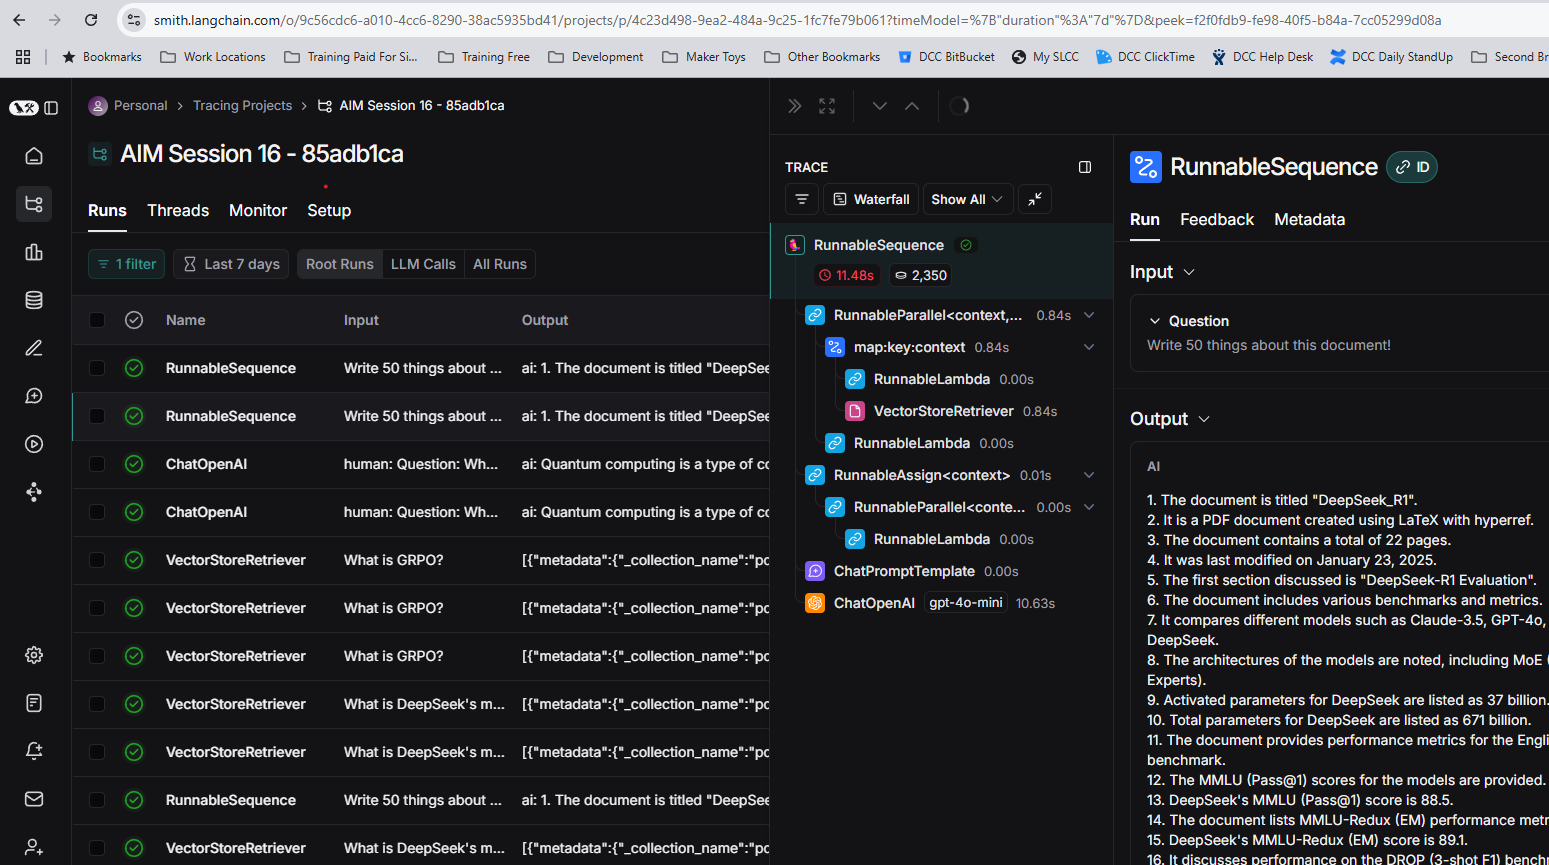

caching:

Caching:
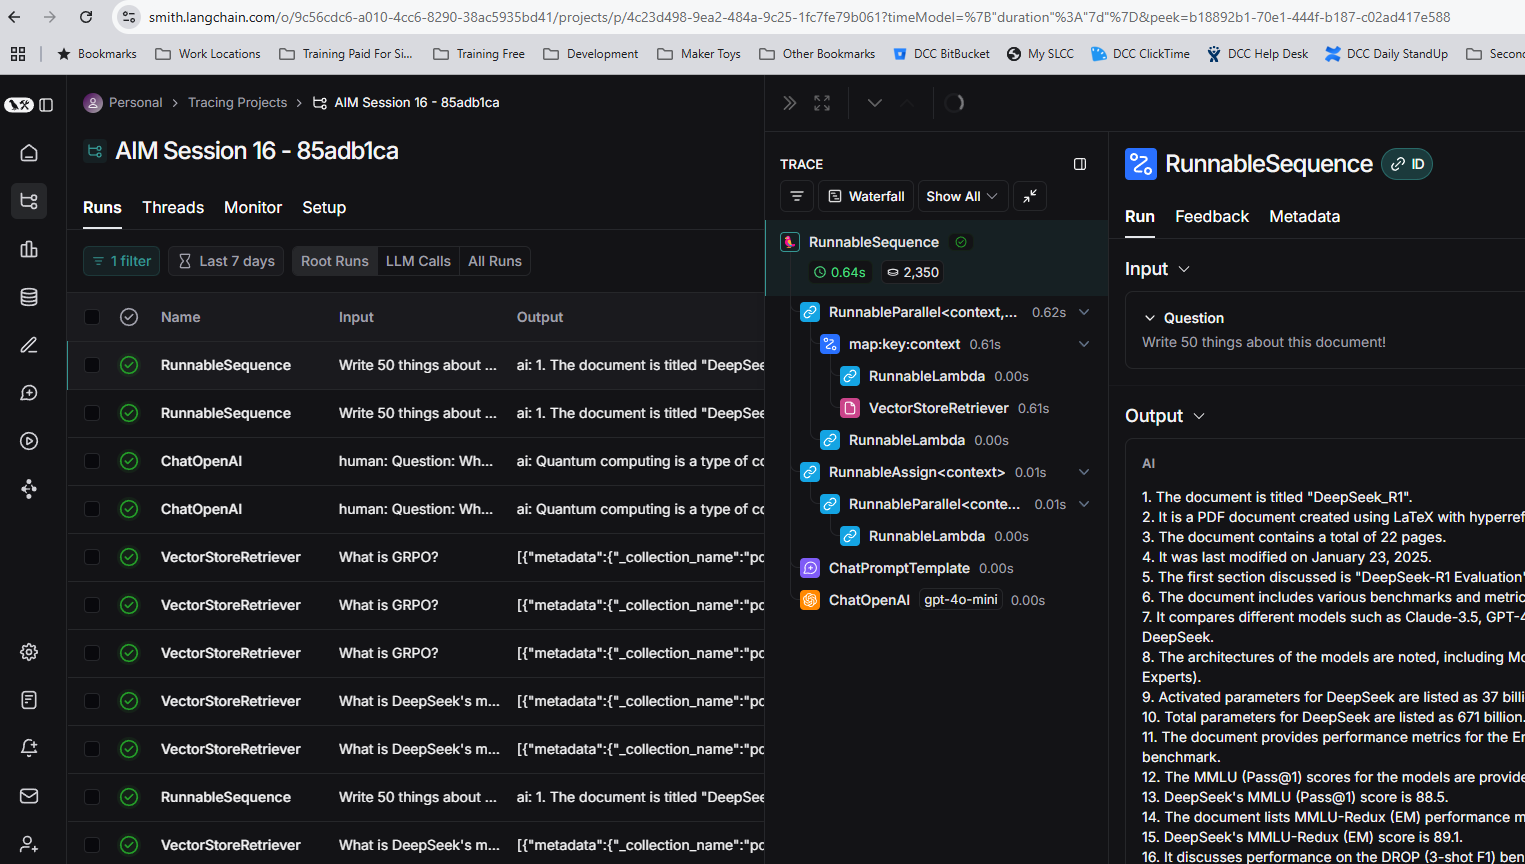

LANGSMITH STUDIO
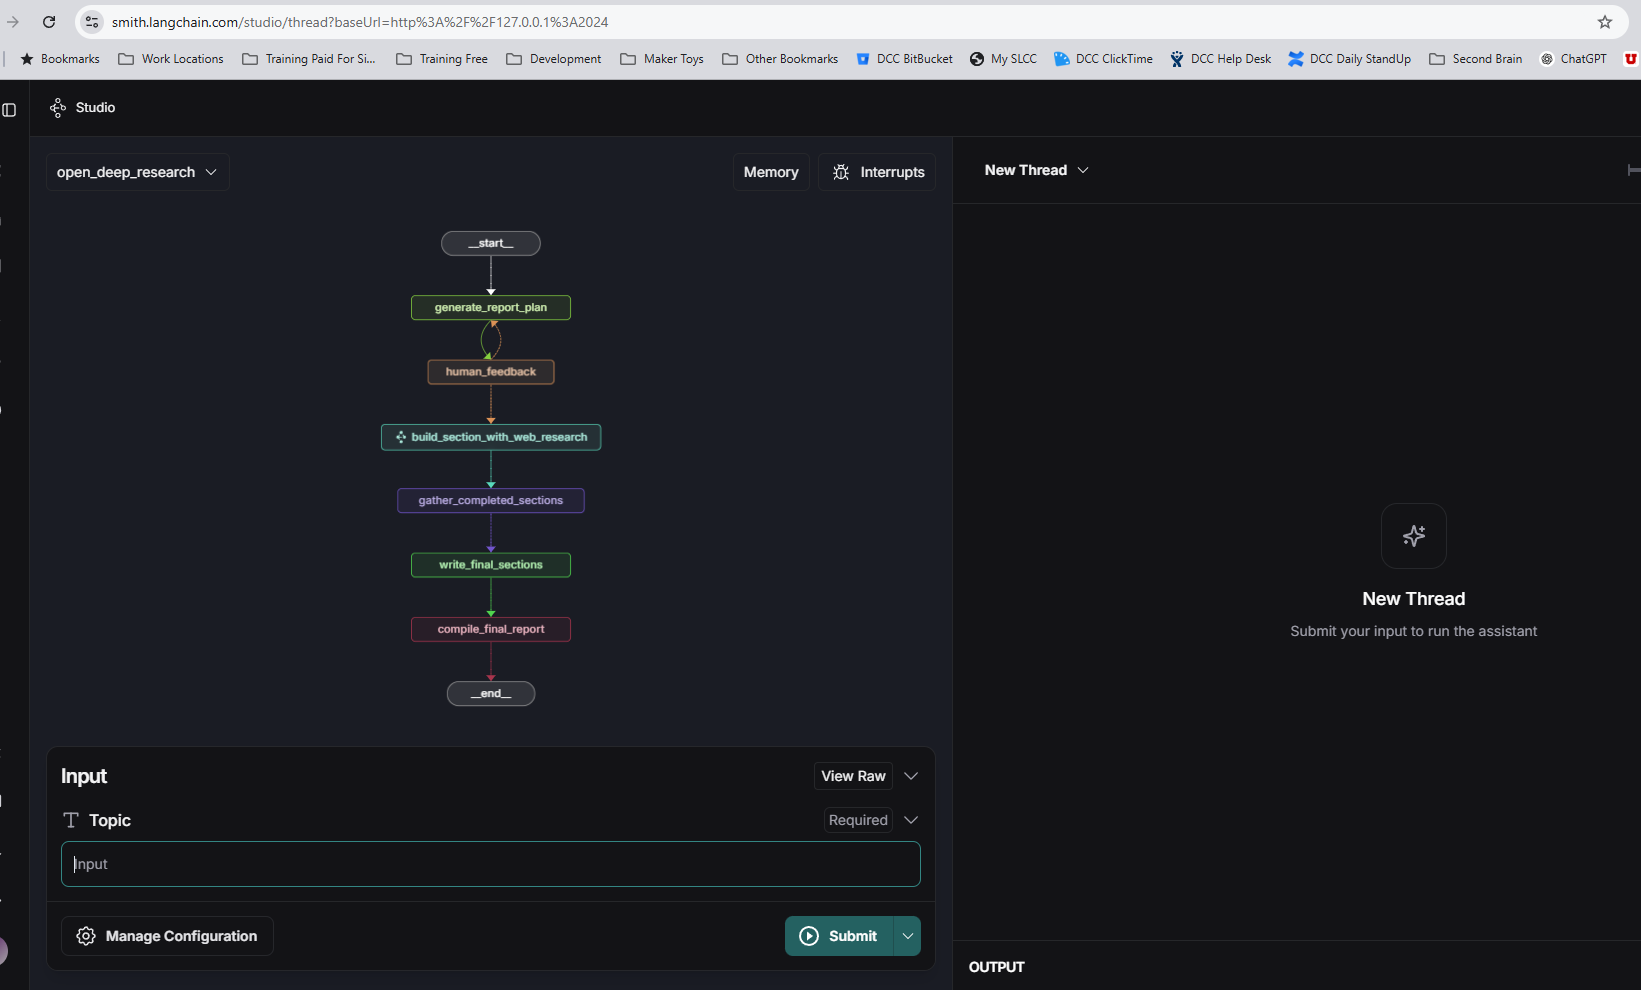